In [1]:
import numpy as np
import pandas as pd
import tempfile
import pprint
import json
import sys
import gym
import pandas as pd
from IPython.core.debugger import Tracer
import scipy.stats

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from gym import wrappers
from subprocess import check_output
from IPython.display import HTML

# Dynamic Programming Methods


In [3]:
mdir = tempfile.mkdtemp()
env = gym.make('FrozenLake-v0')
env = wrappers.Monitor(env, '/tmp/FrozenLake-v0',force=True) #force=True, replaces data in the folder
env.directory

INFO:gym.envs.registration:Making new env: FrozenLake-v0
[2017-07-16 14:32:03,972] Making new env: FrozenLake-v0
INFO:gym.wrappers.monitoring:Clearing 2 monitor files from previous run (because force=True was provided)
[2017-07-16 14:32:04,000] Clearing 2 monitor files from previous run (because force=True was provided)


'/tmp/FrozenLake-v0'

The env variable contains the problem specification. In DP methods, we assume these are known

In [4]:
A = range(env.action_space.n)
S = range(env.observation_space.n)
P = env.env.env.P
P[0][0]

[(0.3333333333333333, 0, 0.0, False),
 (0.3333333333333333, 0, 0.0, False),
 (0.3333333333333333, 4, 0.0, False)]

Value iteration takes advantage of the bellman optimality equations. If you are following the optimal policy, the Bellman equations hold. If not, you can use the discrepancy between the current state's value and the next state's value to update the current state's value. Value iteration is the simplest form of this. 

For k iterations: 
$$ V(s)_k = max_a \sum_{s'} P(s',a,s)(R(s)+ \gamma V(s')_{k-1}) $$

Stop when 
$$ V(s)_k-V(s)_{k-1} < \epsilon$$

In [5]:
def value_iteration(A,S,P,epsilon = 0.0001,gamma = 0.99):
    '''Full Solves a MDP given the model of the environment
    Args:
        A: list action numbers
        S: list of state numbers 
        P: dictionary for transitions. keys are integers for states. P[s][a]. Then there is a list of tuples. 
        The tuple is (prob, next state, r, terminal?)
    
    '''

    # intialize value function
    V = np.random.random(len(S))
    
    for k in range(10000):
        V_prev = V.copy() 
        Q = np.zeros((len(A),len(S)),dtype=float)
        
        for s in S: # sample states in order 
            for a in A:
                for prob, s_prime, reward, done in P[s][a]:
                    Q[a,s]+= prob*(reward +gamma*V_prev[s_prime]* (not done))
                    
            V[s]=np.max(Q[:,s])
        
        if np.all(np.abs(V_prev - V) < epsilon): # check if any previous values haven't changed that much 
            break
            
    pi = np.argmax(Q,axis=0)
    return(pi,V)

So here, I'll actually run value iteration on the MDP and print out the learned policy and value function

optimal policy
[0 3 3 3 0 0 0 0 3 1 0 0 0 2 1 0]


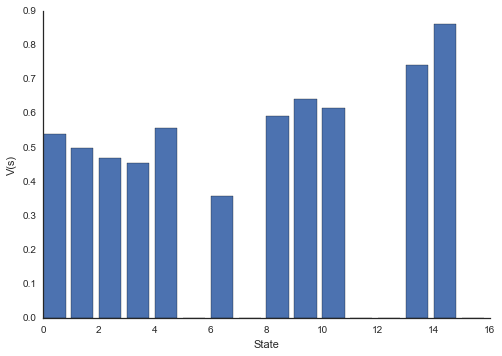

In [6]:
pi,V = value_iteration(A,S,P)
print('optimal policy')
print(pi)
sns.set_style('white')
sns.set_context('notebook')
plt.bar(np.arange(len(V)),V)
sns.despine()
plt.xlabel('State')
plt.ylabel('V(s)')

Here I use the policy to interact with the environment. Because the Monitor was set up, it'll save out a video in a json format. 

In [7]:
#P[state]

In [8]:
for _ in range(2000):
    state = env.reset()
    while True:
        #env.render()
        state, reward, done, info = env.step(pi[state])
        if done:
            break

INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /tmp/FrozenLake-v0/openaigym.video.0.13655.video000000.json
[2017-07-16 14:32:06,374] Starting new video recorder writing to /tmp/FrozenLake-v0/openaigym.video.0.13655.video000000.json
INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /tmp/FrozenLake-v0/openaigym.video.0.13655.video000001.json
[2017-07-16 14:32:06,379] Starting new video recorder writing to /tmp/FrozenLake-v0/openaigym.video.0.13655.video000001.json
INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /tmp/FrozenLake-v0/openaigym.video.0.13655.video000008.json
[2017-07-16 14:32:06,387] Starting new video recorder writing to /tmp/FrozenLake-v0/openaigym.video.0.13655.video000008.json
INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /tmp/FrozenLake-v0/openaigym.video.0.13655.video000027.json
[2017-07-16 14:32:06,408] Starting new video recorder writing to /tmp/FrozenLake-v0/opena

In [12]:
env.close()
gym.upload('/tmp/FrozenLake-v0/',api_key='sk_PP2R5NblSSaI9sECHDhu1g')

INFO:gym.wrappers.monitoring:Finished writing results. You can upload them to the scoreboard via gym.upload('/tmp/FrozenLake-v0')
[2017-07-16 14:32:10,011] Finished writing results. You can upload them to the scoreboard via gym.upload('/tmp/FrozenLake-v0')
INFO:gym.scoreboard.api:[FrozenLake-v0] Uploading 2000 episodes of training data
[2017-07-16 14:32:10,017] [FrozenLake-v0] Uploading 2000 episodes of training data
INFO:gym.scoreboard.api:[FrozenLake-v0] Uploading videos of 11 training episodes (1529 bytes)
[2017-07-16 14:32:12,915] [FrozenLake-v0] Uploading videos of 11 training episodes (1529 bytes)
INFO:gym.scoreboard.api:[FrozenLake-v0] Creating evaluation object from /tmp/FrozenLake-v0/ with learning curve and training video
[2017-07-16 14:32:13,110] [FrozenLake-v0] Creating evaluation object from /tmp/FrozenLake-v0/ with learning curve and training video
INFO:gym.scoreboard.api:
****************************************************
You successfully uploaded your evaluation on Fr

# Q learning

Here we will interact with the environment in an online fasion. We will have to act to get a new observation. 


In [223]:
def Q_learning(env,alpha=0.9,gamma=0.9):
    '''This learning will learn a policy online.
    
    args:
        env: an RL environment

    '''

    # set-up
    A = range(env.action_space.n)
    S = range(env.observation_space.n)
    Q = np.random.random((len(S),len(A)))*2
    
    n_episodes = 10000
    rewards = np.zeros(n_episodes)
    
    epsilons = np.array([])
    for epi,episode in enumerate(range(n_episodes//2, -n_episodes//2, -1)):
        s = env.reset()

        
        # interact with environment until episode ends
        while True:
            
            # choose action in epislon greedy fashion w.r.t policy 
            epsilon = max(0, np.float(episode)/np.float(n_episodes*2.0))
            epp = scipy.stats.binom.rvs(p=epsilon,n=1)
            if epp==1:
                a = np.random.randint(len(A))
            else:
                a = np.argmax(Q[s,:])
            
            # act in the environment
            s_prime, reward, done, info = env.step(a)

            # update
            Q[s,a]+= alpha*(reward + gamma*np.max(Q[s_prime,:])*(not done)-Q[s,a])

            # go to next state 
            s = s_prime 
            
            if done:
                break
        rewards[epi]=reward
        epsilons = np.append(epsilons,epsilon)
    
    return(Q,rewards,epsilons)
    
    

In [224]:
# for ep in range(n_episodes):
#     print(max(0, np.float(1)/(ep+1)))

In [225]:
#ep

In [226]:
# ep=100
# max(0, np.float(ep)/np.float(n_episodes)*2)


In [227]:
# episilon = 0.05
# ep = scipy.stats.binom.rvs(p=episilon,n=1)
# a = np.random.randint(len(A))
# a

In [228]:
mdir = tempfile.mkdtemp()
env = gym.make('FrozenLake-v0')
env = wrappers.Monitor(env, '/tmp/FrozenLake-v0-Q-learning',force=True) #force=True, replaces data in the folder
env.directory

INFO:gym.envs.registration:Making new env: FrozenLake-v0
[2017-07-16 16:40:09,003] Making new env: FrozenLake-v0
INFO:gym.wrappers.monitoring:Finished writing results. You can upload them to the scoreboard via gym.upload('/tmp/FrozenLake-v0-Q-learning')
[2017-07-16 16:40:09,076] Finished writing results. You can upload them to the scoreboard via gym.upload('/tmp/FrozenLake-v0-Q-learning')
INFO:gym.wrappers.monitoring:Clearing 40 monitor files from previous run (because force=True was provided)
[2017-07-16 16:40:09,077] Clearing 40 monitor files from previous run (because force=True was provided)


'/tmp/FrozenLake-v0-Q-learning'

In [229]:
Q,rewards,epsilons = Q_learning(env)


INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /tmp/FrozenLake-v0-Q-learning/openaigym.video.22.13975.video000000.json
[2017-07-16 16:40:09,547] Starting new video recorder writing to /tmp/FrozenLake-v0-Q-learning/openaigym.video.22.13975.video000000.json
INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /tmp/FrozenLake-v0-Q-learning/openaigym.video.22.13975.video000001.json
[2017-07-16 16:40:09,550] Starting new video recorder writing to /tmp/FrozenLake-v0-Q-learning/openaigym.video.22.13975.video000001.json
INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /tmp/FrozenLake-v0-Q-learning/openaigym.video.22.13975.video000008.json
[2017-07-16 16:40:09,557] Starting new video recorder writing to /tmp/FrozenLake-v0-Q-learning/openaigym.video.22.13975.video000008.json
INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /tmp/FrozenLake-v0-Q-learning/openaigym.video.22.13975.video000027.json
[2017

<Container object of 16 artists>

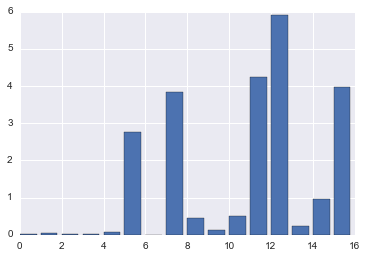

In [230]:
V = np.sum(Q,axis=1)
plt.bar(np.arange(len(V)),V)


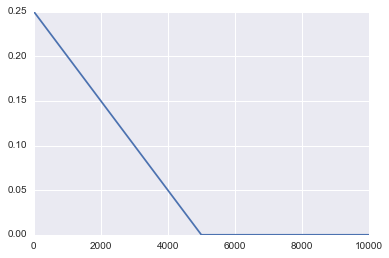

In [231]:
plt.plot(epsilons)

In [236]:
pi = np.argmax(Q,axis=1)
print(pi)

[0 3 3 3 0 0 0 3 3 1 0 1 3 2 1 2]


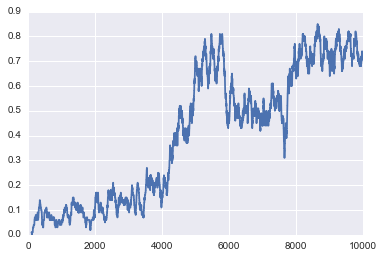

In [233]:
plt.plot(pd.rolling_mean(rewards[0:10000],100))

In [235]:
env.close()
gym.upload('/tmp/FrozenLake-v0-Q-learning/',api_key='sk_PP2R5NblSSaI9sECHDhu1g')

INFO:gym.scoreboard.api:[FrozenLake-v0] Uploading 10000 episodes of training data
[2017-07-16 16:41:36,982] [FrozenLake-v0] Uploading 10000 episodes of training data
INFO:gym.scoreboard.api:[FrozenLake-v0] Uploading videos of 19 training episodes (1962 bytes)
[2017-07-16 16:41:38,407] [FrozenLake-v0] Uploading videos of 19 training episodes (1962 bytes)
INFO:gym.scoreboard.api:[FrozenLake-v0] Creating evaluation object from /tmp/FrozenLake-v0-Q-learning/ with learning curve and training video
[2017-07-16 16:41:38,588] [FrozenLake-v0] Creating evaluation object from /tmp/FrozenLake-v0-Q-learning/ with learning curve and training video
INFO:gym.scoreboard.api:
****************************************************
You successfully uploaded your evaluation on FrozenLake-v0 to
OpenAI Gym! You can find it at:

    https://gym.openai.com/evaluations/eval_0MVqKTTBRFutuNvPUOKofA

****************************************************
[2017-07-16 16:41:39,345] 
*************************************

# Very Simple DQN 

# Hindsight Experience Replay